# BootComp Tutorial (WSC18)

This Jupyter _Python 3_ notebook has been written to accompany the WSC18 paper:

**PRACTICAL CONSIDERATIONS IN SELECTING THE BEST SET OF SIMULATED SYSTEMS**  _by Christine Currie and Tom Monks_.

The notebook provides a worked example of using BootComp to conduct a 2 stage screening and search of a simulation model.  

## 1. Preamble

### 1.1. Detail of the simulation model

The simulation model was used in a 2017 project in the UK to help a hospital, a community healthcare provider and a clinical commissioning group design and plan a new community rehabilitation ward.  In the UK, patients who require rehabilitation are often stuck in a queuing system where there must wait (inappropriately) in a acute hospital bed for a space in the rehabilitaiton ward.  The model investigated the sizing of the new ward in order to minimise patient waiting time whilst meeting probabilitic constraints regarding ward occupancy (bed utilization) and the number of transfers between single sex bays.

<img src="images/DToC.jpg" alt="Delayed Transfers of Care Model" title="Simulation Model and KPIs" />

### 1.2. Output data

The output data for the example analysis are bundled with git repository.  There are three .csv files in the data/ directory for 'waiting times', 'utilization' and 'transfers'.  

The model itself is not needed.  There are 50 replications of 1151 competing designs points.  Users can vary the number of replications used in the two stage procedure.  

The experimental design is also included for reference.

## 2. Prerequisites

### 2.1. BootComp Modules

In [1]:
#WSC18 specific modules
import Bootstrap_wsc18 as wsc
from Bootstrap_wsc18 import constraints_bootstrap, quality_bootstrap
from helper_wsc18 import best_subset_table, get_best_subset, load_model_file


### 2.2. Python Data Science Modules

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os

## 3. Procedure: Stage 1

** Optimization Parameters **

N_BOOTS = no. bootstraps to perform

** Stage 1 **

$n_1$ = no. stage 1 indeptendent replications for each systems / competing design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 1

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system

** Stage 2 **

$n_2$ = no. stage 2 independent replications for each system / competigin design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 2

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system in stage 2

In [3]:
N_BOOTS = 1000
n_1 = 10
n_2 = 40

gamma_1 = 0.7
x_1 = 0.1 
y_1 = 0.95

gamma_2 = 0.95
x_2 = 0.05
y_2 = 0.95


** Chance constraints **

In [4]:
min_util = 80 # ward occupancy >= 80%
max_tran = 50 # transfers between single sex bays <= 50

### Stage 1: Read in initial $ n_1 $  replications

In [17]:
DESIGN = "data/doe.csv"
MODEL_PATH = "data/wsc18_reps"

In [18]:
df_wait, df_util, df_tran = wsc.simulate_stage_1(n_1, load_model_file(MODEL_PATH))

Loaded waiting time data. 1051 systems; 10 replications
Loaded utilzation data. 1051 systems; 10 replications
Loaded transfers data. 1051 systems; 10 replications


In [7]:
df_wait.shape

(10, 1051)

### Stage 1: Limit to systems that satisfy chance constraints

#### Chance constraint 1:  Utilisation Threshold (value for money)

In [8]:
help(constraints_bootstrap)

Help on function constraints_bootstrap in module Bootstrap_wsc18:

constraints_bootstrap(data, threshold, nboots=1000, gamma=0.95, kind='lower')
    Bootstrap a chance constraint for k systems and filter out systems 
    where p% of resamples are greater a threshold t.  
    
    Example 1. A lower limit.  If the chance constaint was related to utilization it could be stated as 
    filter out any systems where 95% of the distribution is greater than 80%.
    
    Example 2. An upper limit.  If the chance constraint related to unwanted ward transfers it could be stated 
    as filter out any systems where 95% of the distribution is less than 50 transfers per annum.
    
    Returns a pandas.Series containing of the feasible systems i.e. that do not violate the chance constraint.
    
    Keyword arguments
    data -- a numpy array of the data to bootstrap
    threshold -- the threshold of the chance constraint
    boot_args -- the bootstrap setup class
    gamma -- the probability cut 

The function below is a convenient way to run chance contraints bootstrap for the 2 constraints.  It can be reused at stage 2.

In [9]:
def constraint_bootstrap_ward_problem(take_forward, df_u, df_t, gamma, nboots=1000):#
    """
    run constraints bootstrap for both chance contraints.  
    Return subset of systems that meets both constraints gamma% of the time.
    Just used for cleaner code.
    
    Keyword arguments:
    take_forward -- systems to test
    df_u -- dataframe containing replications of utilisation measure
    df_t -- dataframe containing replpications of patient transfers measure
    gamma -- test criterion e.g. 0.7, 0.8
    
    """
    passed_1 = constraints_bootstrap(data = df_u.values.T, threshold=min_util, nboots=nboots, gamma=gamma)
    print("Systems meeting MIN Utilisation constraint: {0}".format(passed_1.shape[0]))
    
    passed_2 = constraints_bootstrap(data = df_t.values.T, threshold=max_tran, nboots=nboots, gamma=gamma, kind='upper')
    print("Systems meeting MAX Patient Transfers constraint: {0}".format(passed_2.shape[0]))
          
    mapped_1 = np.array([take_forward[x] for x in passed_1])
    mapped_2 = np.array([take_forward[x] for x in passed_2])
    
    subset = np.intersect1d(mapped_1, mapped_2)
    print("Systems meeting ALL constraints: {0}".format(subset.shape[0]))
    
    return subset

In [10]:
%%time
subset = constraint_bootstrap_ward_problem([i for i in range(df_wait.shape[1])], df_util, df_tran, gamma_1, nboots=N_BOOTS)

Systems meeting MIN Utilisation constraint: 428
Systems meeting MAX Patient Transfers constraint: 798
Systems meeting ALL constraints: 175
CPU times: user 1 s, sys: 52.8 ms, total: 1.05 s
Wall time: 809 ms


List and rank the systems along with their peformance measures

In [11]:
best_system_index, subset_kpi = get_best_subset([df_wait, df_util, df_tran], ['wait', 'util', 'tran'], subset)
best_system_index

358

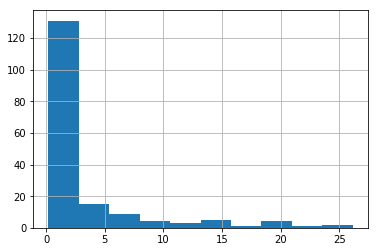

In [12]:
subset_kpi['wait'].hist()

### Stage 1: Quality Bootstrap 

Define set $J$ where y% of bootstraps are within x% of the best mean




In [13]:
help(quality_bootstrap)

Help on function quality_bootstrap in module Bootstrap_wsc18:

quality_bootstrap(feasible_systems, subset, best_system_index, x=0.1, y=0.95, nboots=1000)
    1. Create differences of systems from best system
    2. Create nboots bootstrap datasets of the differences
    3. Return a DataFrame with all systems that are x% of feasible_systems[best_system_index] in y% of the boostrap samples
    
    Keyword arguments:
    feasible_systems -- systems that meet chance constraints (if there are any)
    subset -- list of system indexes that are feasible
    best_system_index -- index of the best system within @feasible_systems
    args - Instance of a BootstrapArguments class
    x -- % tolerance of difference from best mean allowed (default = 0.1)
    y -- % of boostrap samples that must be within tolerance x of best mean (default = 0.95)
    nboots = number of bootstrap datasets to create (default = 1000)



In [14]:
%%time
feasible_systems = df_wait[subset]
take_forward = quality_bootstrap(feasible_systems, subset, best_system_index, nboots=N_BOOTS, x=x_1, y=y_1)


CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 134 ms


In [15]:
no_stage1 = take_forward.shape[0]
no_stage1

35

_Quick look at stage 1 results_

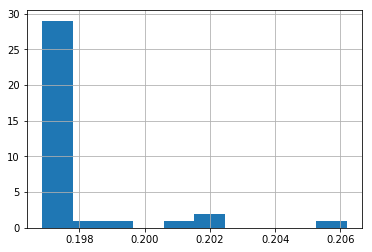

In [16]:
best_subset_table(subset_kpi, take_forward, DESIGN)['wait'].hist()

## 4. Procedure - Stage 2

### More replicates of promising solutions using Common Random Numbers

User simulates $ n_2 $ additional replicates for the feasible solutions brought forward from stage 1.

Example = 50 replicates (45 extra)

In [19]:
df_wait_s2, df_util_s2, df_tran_s2 = wsc.simulate_stage_2(take_forward, load_model_file(MODEL_PATH))

Loaded waiting time data. 35 systems; 50 replications
Loaded utilzation data. 35 systems; 50 replications
Loaded transfers data. 35 systems; 50 replications


### Stage 2 Constraints Bootstrap

In [20]:
%time
subset = constraint_bootstrap_ward_problem(take_forward, df_util_s2, df_tran_s2, gamma_2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Systems meeting MIN Utilisation constraint: 35
Systems meeting MAX Patient Transfers constraint: 32
Systems meeting ALL constraints: 32


In [21]:
best_system_index, subset_kpi = get_best_subset([df_wait_s2, df_util_s2, df_tran_s2], ['wait', 'util', 'tran'], subset)
best_system_index

403

### Stage 2 Quality Bootstrap

In [22]:
feasible_systems = df_wait_s2[subset]
final_set = quality_bootstrap(feasible_systems, subset, best_system_index, nboots=N_BOOTS, x = x_2, y=y_2)
final_set.shape

(28,)

## Visualise Final Solution

In [24]:
df_final = best_subset_table(subset_kpi, final_set, DESIGN)
df_final

,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,util,tran
System,,,,,,,
403,48,9,2,30,0.203996,81.010689,29.46
369,48,4,4,32,0.204240,81.011203,22.70
398,48,8,2,32,0.204240,81.011775,26.16
352,48,0,0,48,0.204245,81.011717,0.00
367,48,4,2,40,0.204245,81.011717,12.46
353,48,3,3,39,0.204245,81.011717,12.72
378,48,5,2,38,0.204245,81.011717,15.88
354,48,3,4,36,0.204245,81.011717,16.54
368,48,4,3,36,0.204245,81.011717,17.32


In [ ]:
df_final.to_clipboard()

## Charts for paper

In [ ]:
df_doe = pd.read_csv(DESIGN, index_col='System')
df_doe.index -= 1

Utilisation

In [ ]:
temp = df_doe.loc[df_doe['Number of Bays']==0]
#temp.index += 1
subset_waits = df_wait[temp.index].mean()
subset_waits.rename('wait', inplace=True)
subset_utils = df_util[temp.index].mean()
subset_utils.rename('util', inplace=True)
subset_trans = df_tran[temp.index].mean()
subset_trans.rename('tran', inplace=True)



subset_utils_sem = df_util[temp.index].sem()
subset_utils_sem.rename('util_sem', inplace=True)

subset_utils_count = df_util[temp.index].count()
subset_utils_count.rename('n_util', inplace=True)

import scipy as sp
import scipy.stats
import seaborn as sns

subset_kpi = pd.concat([temp, subset_waits, subset_utils, subset_trans, subset_utils_sem, subset_utils_count], axis = 1)
subset_kpi['Waiting Time (hrs)'] = round(subset_kpi['wait']*24, 2)

confidence = 0.95

subset_kpi['hw_95'] = subset_kpi['util_sem'] * sp.stats.t.ppf((1+confidence)/2., subset_kpi['n_util']-1)

#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False)

subset_kpi.sort_values('util').plot(y = 'util', x= 'Number of Singles', figsize=(20, 8), fontsize = 18, 
                                    linewidth=3, legend =False, kind='scatter', ax=axes[1], xticks=[x for x in range(43, 56, 1)], xlim=(42, 56), yerr='hw_95')#, xlim=(70, 92), ylim=(0, 35))
axes[0].set_ylabel('Mean Waiting Time (hrs)', fontsize = 18)
axes[1].set_xlabel('Number of Singles (beds)', fontsize = 18)




subset_kpi.plot('Number of Singles', 'Waiting Time (hrs)', figsize=(20, 8), fontsize = 18, 
                                    linewidth=3, legend =False, kind='line', ms=10, style='o-', ax=axes[0], xlim=(42, 56),
                                    xticks=[x for x in range(43, 56, 1)])
axes[0].set_xlabel('Number of Singles (beds)', fontsize = 18)
axes[1].set_ylabel('Mean Utilization (% beds)', fontsize = 18)
axes[0].grid(True)
axes[1].grid(True)
axes[1].legend(['mean (n=5)','95% Confidence Interval'],fontsize=18)
#plt.tight_layout()

In [ ]:
fig.savefig("chance_constraint_stage1.pdf", format = 'pdf', dpi=600, bbox_inches='tight')

In [ ]:
subset_kpi